In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# **Questão 1. Contando palitinhos :)**

In [8]:
image = cv2.imread('jogo-dos-palitos.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)


In [9]:
low_threshold = 50
high_threshold = 150
edges = cv2.Canny(blurred, low_threshold, high_threshold)

In [10]:
def hough_line(edges):
    height, width = edges.shape

    max_rho = int(np.sqrt(height**2 + width**2))
    rhos = np.arange(-max_rho, max_rho + 1, 1) 
    thetas = np.deg2rad(np.arange(-90, 90, 1)) 

    accumulator = np.zeros((len(rhos), len(thetas)), dtype=np.uint64)

    cos_thetas = np.cos(thetas)
    sin_thetas = np.sin(thetas)

    for y in range(height):
        for x in range(width):
            if edges[y, x] > 0: 
                for t_idx, theta in enumerate(thetas):
                    rho = int(x * cos_thetas[t_idx] + y * sin_thetas[t_idx])
                    rho_idx = np.where(rhos == rho)[0][0]
                    accumulator[rho_idx, t_idx] += 1
    return accumulator, rhos, thetas

accumulator, rhos, thetas = hough_line(edges)

threshold_votes = 150

detected_lines = []
for r_idx, rho in enumerate(rhos):
    for t_idx, theta in enumerate(thetas):
        if accumulator[r_idx, t_idx] > threshold_votes:
            detected_lines.append((rho, theta))

filtered_lines = []
rho_threshold = 10 
theta_threshold = np.deg2rad(5) 

for r1, t1 in detected_lines:
    is_duplicate = False
    for r2, t2 in filtered_lines:
        if np.abs(r1 - r2) < rho_threshold and np.abs(t1 - t2) < theta_threshold:
            is_duplicate = True
            break
    if not is_duplicate:
        filtered_lines.append((r1, t1))

line_image = np.copy(image)
for rho, theta in filtered_lines:
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho
    y0 = b * rho
    x1 = int(x0 + 1000 * (-b))
    y1 = int(y0 + 1000 * (a))
    x2 = int(x0 - 1000 * (-b))
    y2 = int(y0 - 1000 * (a))
    cv2.line(line_image, (x1, y1), (x2, y2), (0, 255, 0), 2) # Green lines


Número estimado de varetas: 16


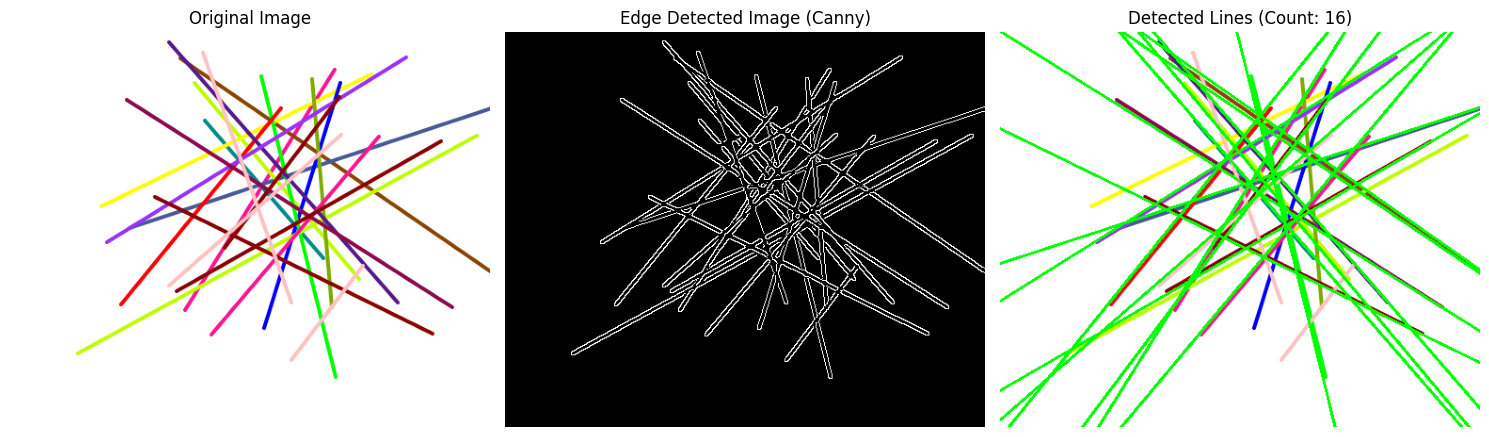

In [11]:

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Edge Detected Image (Canny)')
plt.imshow(edges, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title(f'Detected Lines (Count: {len(filtered_lines)})')
plt.imshow(cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.tight_layout()
plt.savefig('detected_sticks.png')
print(f"Número estimado de varetas: {len(filtered_lines)}")


---

# **Questão 2. Contando hemácias ;)**

In [47]:
def hough_circle_manual_with_votes(edges, gradient_x, gradient_y, min_radius, max_radius):
    """
    Implementa manualmente a Transformada de Hough para Círculos, utilizando a direção do gradiente.
    Retorna os círculos detectados junto com suas contagens de votos.

    Args:
        edges (np.array): Imagem binária de bordas (saída do Canny).
        gradient_x (np.array): Imagem do gradiente X (ex: Sobel).
        gradient_y (np.array): Imagem do gradiente Y (ex: Sobel).
        min_radius (int): Raio mínimo a ser detectado.
        max_radius (int): Raio máximo a ser detectado.

    Returns:
        list: Uma lista de círculos detectados, cada um como (center_x, center_y, radius, votes).
    """
    height, width = edges.shape
    accumulator_radius_range = max_radius - min_radius + 1
    accumulator = np.zeros((width, height, accumulator_radius_range), dtype=np.uint32)

    magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
    magnitude[magnitude == 0] = 1e-6 

    for y in range(height):
        for x in range(width):
            if edges[y, x] > 0: 
                gx = gradient_x[y, x] / magnitude[y, x]
                gy = gradient_y[y, x] / magnitude[y, x]

                for r_val in range(min_radius, max_radius + 1):
                    center_x_float = x - r_val * gx
                    center_y_float = y - r_val * gy

                    center_x = int(round(center_x_float))
                    center_y = int(round(center_y_float))

                    if 0 <= center_x < width and 0 <= center_y < height:
                        radius_idx = r_val - min_radius
                        accumulator[center_x, center_y, radius_idx] += 1
    
    raw_detected_circles_with_votes = []
    for cx in range(width):
        for cy in range(height):
            for r_idx in range(accumulator_radius_range):
                votes = accumulator[cx, cy, r_idx]
                if votes > 0: 
                    raw_detected_circles_with_votes.append((cx, cy, r_idx + min_radius, votes))
                    
    return raw_detected_circles_with_votes


In [49]:
def count_red_blood_cells(image_path,
                          canny_low_threshold=30,
                          canny_high_threshold=100,
                          min_radius=15, 
                          max_radius=20, 
                          hough_threshold_votes=100, 
                          min_dist_circles=20, 
                          show_plots=True):
    """
    Estima o número de hemácias em uma imagem usando a Transformada de Hough circular manual.

    Args:
        image_path (str): Caminho para a imagem.
        canny_low_threshold (int): Limiar inferior para o detector de bordas Canny.
        canny_high_threshold (int): Limiar superior para o detector de bordas Canny.
        min_radius (int): Raio mínimo dos círculos a serem detectados.
        max_radius (int): Raio máximo dos círculos a serem detectados.
        hough_threshold_votes (int): Votos mínimos no acumulador para um círculo ser considerado.
        min_dist_circles (int): Distância mínima entre os centros dos círculos detectados para evitar duplicatas.
        show_plots (bool): Se True, exibe as imagens intermediárias e finais.

    Returns:
        int: O número estimado de hemácias. Retorna -1 se a imagem não for encontrada.
    """
    try:
        image = cv2.imread(image_path)
        if image is None:
            raise FileNotFoundError(f"Erro: Imagem '{image_path}' não encontrada.")
    except FileNotFoundError as e:
        print(e)
        return -1

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    edges = cv2.Canny(blurred, canny_low_threshold, canny_high_threshold)

    gradient_x = cv2.Sobel(blurred, cv2.CV_64F, 1, 0, ksize=3)
    gradient_y = cv2.Sobel(blurred, cv2.CV_64F, 0, 1, ksize=3)

    raw_detected_circles_with_votes = hough_circle_manual_with_votes(edges, gradient_x, gradient_y,
                                                                     min_radius, max_radius)

    thresholded_circles = [c for c in raw_detected_circles_with_votes if c[3] > hough_threshold_votes]
    
    thresholded_circles.sort(key=lambda x: x[3], reverse=True)

    final_circles = []
    
    while thresholded_circles:
        best_circle = thresholded_circles.pop(0) # Pega o círculo mais forte restante
        final_circles.append((best_circle[0], best_circle[1], best_circle[2])) # Adiciona suas coordenadas (cx, cy, r)
        
        remaining_circles = []
        for circle in thresholded_circles:
            cx1, cy1, r1 = best_circle[0], best_circle[1], best_circle[2]
            cx2, cy2, r2 = circle[0], circle[1], circle[2]
            
            distance = np.sqrt((cx1 - cx2)**2 + (cy1 - cy2)**2)
            
            if distance < min_dist_circles:
                pass
            else:
                remaining_circles.append(circle)
        thresholded_circles = remaining_circles

    num_cells = len(final_circles)

    if show_plots:
        circle_image = np.copy(image)
        for (x, y, r) in final_circles:
            cv2.circle(circle_image, (x, y), r, (0, 255, 0), 2) 

        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.title('Imagem Original')
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.title('Bordas (Canny)')
        plt.imshow(edges, cmap='gray')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.title(f'Células Detectadas (Contagem: {num_cells})')
        plt.imshow(cv2.cvtColor(circle_image, cv2.COLOR_BGR2RGB))
        plt.axis('off')

        plt.tight_layout()
        plt.savefig('detected_hemacias.png')

    return num_cells

Número estimado de hemácias: 208


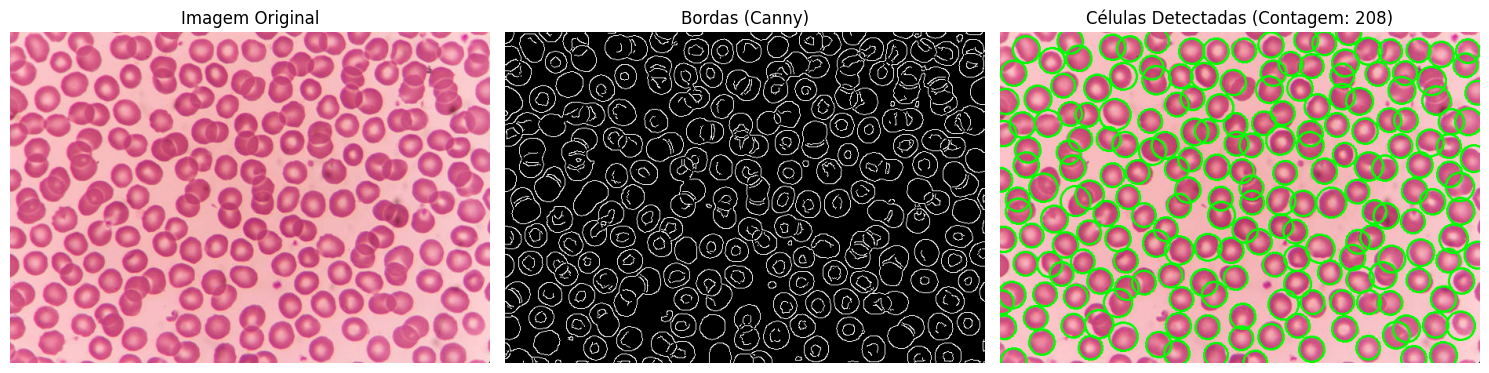

In [68]:

params_optimized_radius = {
    'canny_low_threshold': 30,  
    'canny_high_threshold': 90,
    'min_radius': 15,           
    'max_radius': 20,           
    'hough_threshold_votes': 5, 
    'min_dist_circles': 15,     
    'show_plots': True
}

num_hemacias_final = count_red_blood_cells('Hemacias.jpg', **params_optimized_radius)

if num_hemacias_final != -1:
    print(f"Número estimado de hemácias: {num_hemacias_final}")

# **Questão 3. Implementação Sinograma (˵ ͡° ͜ʖ ͡°˵)**

In [ ]:
def generate_sinogram(image_path, theta_resolution_points=100, rho_resolution_points=82):
    """
    Gera um sinograma (variação da Transformada de Hough para retas)
    onde cada pixel da imagem contribui com uma senoide no espaço (theta, rho),
    com intensidade proporcional à intensidade do pixel.
    Esta versão é vetorizada para maior eficiência.

    Args:
        image_path (str): Caminho para a imagem de entrada.
        theta_resolution_points (int): Número de pontos (colunas) para theta entre 0 e pi.
        rho_resolution_points (int): Número de pontos (linhas) para rho.

    Returns:
        np.array: O sinograma gerado.
        np.array: Os valores de theta utilizados.
        np.array: Os valores de rho utilizados.
    """
    try:
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            raise FileNotFoundError(f"Erro: Imagem '{image_path}' não encontrada.")
    except FileNotFoundError as e:
        print(e)
        return None, None, None

    height, width = image.shape

    thetas = np.linspace(0, np.pi, theta_resolution_points, endpoint=False)

    rho_min_val = -820
    rho_max_val = 820
    rho_step = (rho_max_val - rho_min_val) / (rho_resolution_points - 1)
    rhos = np.linspace(rho_min_val, rho_max_val, rho_resolution_points)

    sinogram = np.zeros((len(rhos), len(thetas)), dtype=np.float32)

    cos_thetas = np.cos(thetas)
    sin_thetas = np.sin(thetas)

    y_coords, x_coords = np.indices(image.shape) 

    all_rhos = (x_coords[:, :, np.newaxis] * cos_thetas +
                y_coords[:, :, np.newaxis] * sin_thetas)

    all_rho_indices = ((all_rhos - rho_min_val) / rho_step).astype(int)

    for t_idx in range(len(thetas)):
        current_rho_indices = all_rho_indices[:, :, t_idx]
        current_pixel_intensities = image 

        valid_indices_mask = (current_rho_indices >= 0) & (current_rho_indices < len(rhos))

        np.add.at(sinogram, (current_rho_indices[valid_indices_mask], t_idx),
                  current_pixel_intensities[valid_indices_mask])

    return sinogram, rhos, thetas

In [63]:
image_file = "baldtin1000pb.png" 
theta_points = 100 
rho_points = 82    

sinogram_img, rhos_axis, thetas_axis = generate_sinogram(image_file, theta_points, rho_points)

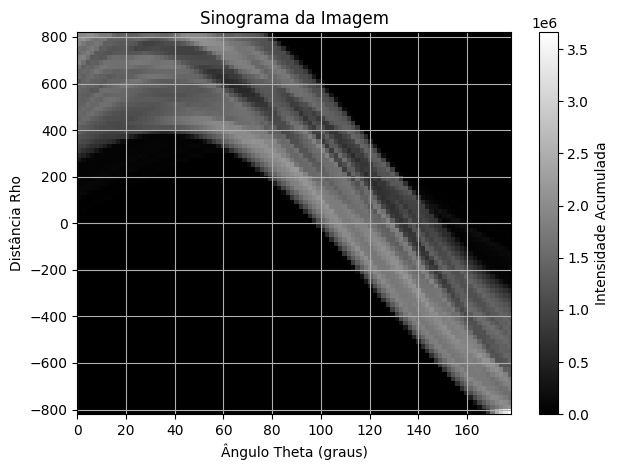

Sinograma gerado e salvo como 'sinograma_baldtin1000pb.png'.
Dimensões do sinograma: (82, 100) (rho x theta)
Valores de theta (primeiros 5): [0.  1.8 3.6 5.4 7.2] ... graus
Valores de rho (primeiros 5): [-820.         -799.75308642 -779.50617284 -759.25925926 -739.01234568] ...
Valores de rho (últimos 5): [739.01234568 759.25925926 779.50617284 799.75308642 820.        ]


In [64]:

if sinogram_img is not None:
    plt.imshow(sinogram_img,
               extent=[np.degrees(thetas_axis[0]), np.degrees(thetas_axis[-1]), rhos_axis[0], rhos_axis[-1]],
               aspect='auto',
               cmap='gray', 
               origin='lower') 
    plt.colorbar(label='Intensidade Acumulada')
    plt.title('Sinograma da Imagem')
    plt.xlabel('Ângulo Theta (graus)')
    plt.ylabel('Distância Rho')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('sinograma_baldtin1000pb.png')
    plt.show()

    print(f"Sinograma gerado e salvo como 'sinograma_baldtin1000pb.png'.")
    print(f"Dimensões do sinograma: {sinogram_img.shape} (rho x theta)")
    print(f"Valores de theta (primeiros 5): {np.degrees(thetas_axis[:5])} ... graus")
    print(f"Valores de rho (primeiros 5): {rhos_axis[:5]} ...")
    print(f"Valores de rho (últimos 5): {rhos_axis[-5:]}")
else:
    print("Não foi possível gerar o sinograma devido a um erro.")